In this notebook, we will cover the following topics: 

1. Implementing kernel regression from scratch using the Laplace kernel. 
2. Showcasing the effect of tuning the bandwidth parameter during kernel regression. 
3. Comparing the performance and runtime of kernel ridge regression and standard implementations of kernels in sklearn (e.g. SVMs). 

## 1. Implementing Kernel Regression from Scratch

As usual we begin by sampling some toy data.  This time, we will sample data according to the function $f(x) = \sin(10x)$.  

In [67]:
import numpy as np

# Don't forget to set your random seeds so that experiments are all reproducible
SEED = 1717
np.random.seed(SEED)

def sample_data(num_samples):
    X = np.random.uniform(size=(num_samples, 1))
    y = np.sin(10 * X)
    return X, y

n_train, n_test = 30, 1000
X_train, y_train = sample_data(n_train)
X_test, y_test = sample_data(n_test)

# I will be sorting X_test, y_test so that I can easily visualize the test data as a curve
X_test, y_test = zip(*sorted(zip(X_test, y_test), key=lambda x: x[0][0]))
X_test = np.array(X_test)
y_test = np.array(y_test)

As is good practice, we will visualize the data to see what it looks like.

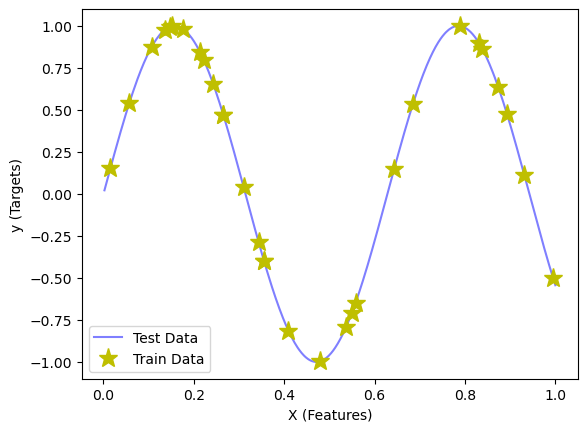

In [68]:
import matplotlib.pyplot as plt

plt.plot(X_test.reshape(-1), y_test.reshape(-1), 'b-', alpha=.5, label='Test Data')
plt.plot(X_train.reshape(-1), y_train.reshape(-1), 'y*', markersize=14, label='Train Data')
plt.xlabel('X (Features)')
plt.ylabel('y (Targets)')
plt.legend()
plt.show()

We then implement the Laplace kernel in a naive fashion using for loops below.

In [69]:
from numpy.linalg import norm 

# Some code for non-vectorized Laplace kernel 
def laplace_naive(x, z, L=10):
    return np.exp(-norm(x - z) / L)

Next, we will use the kernel and training data above to solve kernel regression and visualize the corresponding solution.  Recall that solving kernel regression involves two steps:

1. Build the kernel matrix $K = K(X, X) \in \mathbb{R}^{n \times n}$.
2. Solve the linear system of equations $\alpha K = y$.

In [70]:
from numpy.linalg import solve 
import time 

start = time.time()
# Step 1: Build K(X_train, X_train)
L = 10  # Select a bandwidth for Laplace kernel (10 is usually a good choice)
K = np.zeros((n_train, n_train))
for i in range(n_train):
    for j in range(n_train):
        K[i, j] = laplace_naive(X_train[i], X_train[j], L=L)
        
# Step 2: Solve a linear system of equations corresponding to alpha K = y
alpha = solve(K, y_train)  # Note the shape of alpha is n_train x 1
end = time.time()
print("Total training time: ", end - start)

Total training time:  0.01688694953918457


So now we have just solved kernel regression.  Notice again that this was very few lines of code.  Let us see how our predictor performs on test data now.  Recall that unlike linear regression, we need to transform our test data to the right space before multiplying by $\alpha$ above.  Namely for prediction, we need to follow these steps:

1. $k = K(X, x)$
2. $f(x) = \alpha k$.

In [71]:
from sklearn.metrics import r2_score

start = time.time()
# Step 1: Build k = K(X, x)
k = np.zeros((n_test, n_train))
for i in range(n_test):
    for j in range(n_train):
        k[i, j] = laplace_naive(X_test[i], X_train[j], L=L)

# Step 2: Compute f(x) = alpha k 
test_pred = k @ alpha 
end = time.time()
print("Total prediction time: ", end - start)

Total prediction time:  0.19385600090026855


Test R2 Score:  0.9975096029760911


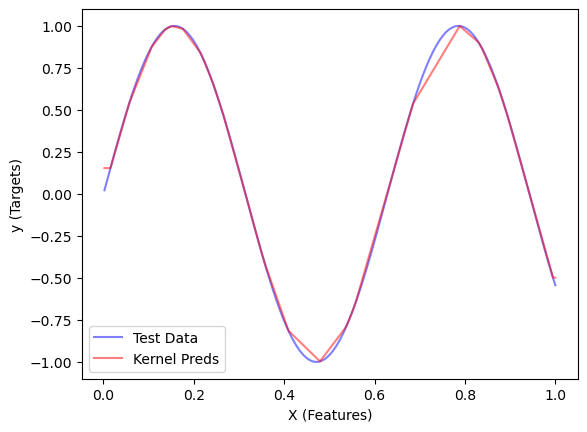

In [72]:
# Measure test R^2 for our predictor
test_r2 = r2_score(y_test, test_pred)
print("Test R2 Score: ", test_r2)  

plt.plot(X_test.reshape(-1), y_test.reshape(-1), 'b-', alpha=.5, label='Test Data')
plt.plot(X_test.reshape(-1), test_pred.reshape(-1), 'r-', alpha=.5, label='Kernel Preds')
plt.xlabel('X (Features)')
plt.ylabel('y (Targets)')
plt.legend()
plt.show()

For the example above, we see that the Laplace kernel gives terrific performance, and this is corroborated by the fact that the $R^2$ is almost $1$.  However, we have unfortunately written the above code using for loops and this will slow things down drastically.  Below, we share an implementation of Laplace kernel that is vectorized, i.e. we remove the for loops and use matrix and vector computations available in NumPy.  

Vectorization is a tremendously useful tool in practice and is a driving force behind drastic speed ups in machine learning models.  It may be worth your while to walk through the operations below slowly and try implementing them yourself to understand how vectorization works.  

In [73]:
def euclidean_distances(samples, centers, squared=True):
    samples_norm = np.sum(samples**2, axis=1, keepdims=True)
    if samples is centers:
        centers_norm = samples_norm
    else:
        centers_norm = np.sum(centers**2, axis=1, keepdims=True)
    centers_norm = np.reshape(centers_norm, (1, -1))
    distances = samples @ centers.T
    distances *= -2
    distances = distances + samples_norm + centers_norm
    if not squared:
        distances = np.where(distances < 0, 0, distances)
        distances = np.sqrt(distances)

    return distances

def laplacian(samples, centers, bandwidth):
    assert bandwidth > 0
    kernel_mat = euclidean_distances(samples, centers, squared=False)
    kernel_mat = np.where(kernel_mat < 0, 0, kernel_mat)
    gamma = 1. / bandwidth
    kernel_mat *= -gamma
    kernel_mat = np.exp(kernel_mat)
    return kernel_mat

class LaplaceKernel():

    def __init__(self, L=10):
        self.sol = None
        self.L = L
        self.X_train = None

    def fit(self, X, y, reg=0):
        self.X_train = X
        K = laplacian(X, X, self.L)
        sol = solve(K + reg * np.eye(len(K)), y).T
        self.sol = sol
        return self

    def predict(self, X):
        K = laplacian(self.X_train, X, self.L)
        return (self.sol @ K).T

We will now redo the example above using the ```LaplaceKernel``` class defined above.  

In [74]:
model = LaplaceKernel()
start = time.time()
model.fit(X_train, y_train)
end = time.time()
training_time = end - start

start = time.time()
test_pred = model.predict(X_test)
end = time.time()
prediction_time = end - start

print("Total training time: ", end - start, " Total prediction time: ", end - start)

Total training time:  0.002145051956176758  Total prediction time:  0.002145051956176758


Test R2 Score:  0.997509602976091


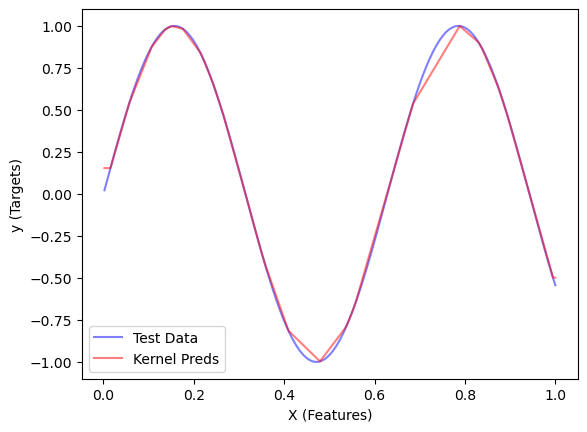

In [75]:
# Measure test R^2 for our predictor
test_r2 = r2_score(y_test, test_pred)
print("Test R2 Score: ", test_r2)  

plt.plot(X_test.reshape(-1), y_test.reshape(-1), 'b-', alpha=.5, label='Test Data')
plt.plot(X_test.reshape(-1), test_pred.reshape(-1), 'r-', alpha=.5, label='Kernel Preds')
plt.xlabel('X (Features)')
plt.ylabel('y (Targets)')
plt.legend()
plt.show()

Comparing the vectorized code above to the for loop implementation, notice that the training and prediction times of the vectorized code are orders of magnitude smaller than that of the for loop code (prediction time without vectorization is .19 and .002 with vectorization for example).  

## 2. The Effect of Bandwidth and Ridge Regularization

We will now illustrate the effect of changing the bandwidth parameter $L$ and ridge regularization can affect performance of kernel machines.  

## 3.  Comparison between SVMs and Ridge Regression

AKA - Please always try the kernel ridge regression first before SVMs since the latter are terribly slow when using a standard library.  